In [155]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
import shutil

plt.ion()

In [156]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
    ]),
    
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
    ]),
    
    'test': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
    ]),
}

In [157]:
data_dir = 'hymenoptera_data'
dsets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val','test']
}

dset_loaders = {
    x: torch.utils.data.DataLoader(dsets[x], batch_size=4, shuffle=True, num_workers=4)
    for x in ['train', 'val','test']
}

dset_sizes = {
    x: len(dsets[x])
    for x in ['train', 'val','test']
}

dset_classes = dsets['train'].classes

use_gpu = torch.cuda.is_available()
    

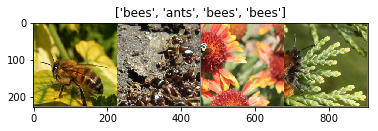

In [158]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs, classes = next(iter(dset_loaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title = [dset_classes[x] for x in classes])

In [52]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()
    filename = 'checkpoint.pth.tar'
    
    
    best_model = model
    best_acc = 0.0
    starting_epoch = 0

    if os.path.isfile(filename):
        print('Loading checkpoint {}'.format(filename))
        loaded_model = torch.load(filename)
        starting_epoch = loaded_model['epoch']
        best_acc = loaded_model['best_acc']
        model.load_state_dict(loaded_model['state_dict'])
        optimizer.load_state_dict(loaded_model['optimizer'])
        print('Loaded checkpoint {}, Starting at epoch {}'.format(filename, loaded_model['epoch']))
    else:
        print('No checkpoint found')
    
    

    
    for epoch in range(starting_epoch, num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer,epoch)
                model.train(True)
            else:
                model.train(False)
                
            running_loss = 0.0
            running_corrects = 0
            
            for data in dset_loaders[phase]:
                inputs, labels = data
                
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                
                optimizer.zero_grad()
                
                outputs = model(inputs)
                _,pred = torch.max(outputs.data,1)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.data[0]
                running_corrects += torch.sum(pred == labels.data)
                
            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            
            is_best = epoch_acc > best_acc
            
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'best_acc': best_acc,
                'optimizer' : optimizer.state_dict(),
            }, is_best)
            
            
            if phase == 'val' and is_best:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best val acc: {:.4f}'.format(best_acc))
    return best_model

In [53]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    lr = init_lr * (0.1 ** (epoch // lr_decay_epoch))
    
    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))
        
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
    return optimizer

In [54]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dset_loaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[labels.data[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [55]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [56]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs,2)

if use_gpu:
    model_conv = model_conv.cuda()
    
    
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

In [57]:
model_conv = train_model(model_conv, criterion,optimizer_conv,exp_lr_scheduler,num_epochs=25)

#torch.save(model_conv.state_dict(),'bees_vs_ants_finetune_fixed_feature_extractor_model')

Loading checkpoint checkpoint.pth.tar
Loaded checkpoint checkpoint.pth.tar, Starting at epoch 5
Epoch 5/24
----------
train Loss: 0.1513 Acc: 0.7541
val Loss: 0.0744 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.0971 Acc: 0.8320
val Loss: 0.0461 Acc: 0.9281

Epoch 7/24
----------
LR is set to 0.0001
train Loss: 0.0905 Acc: 0.8402
val Loss: 0.0524 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.0880 Acc: 0.8320
val Loss: 0.0533 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.1026 Acc: 0.8115
val Loss: 0.0483 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.0922 Acc: 0.8402
val Loss: 0.0518 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.0902 Acc: 0.8566
val Loss: 0.0504 Acc: 0.9216

Epoch 12/24
----------
train Loss: 0.0756 Acc: 0.8648
val Loss: 0.0490 Acc: 0.9281

Epoch 13/24
----------
train Loss: 0.0823 Acc: 0.8566
val Loss: 0.0495 Acc: 0.9020

Epoch 14/24
----------
LR is set to 1.0000000000000003e-05
train Loss: 0.0842 Acc: 0.8402
val Loss: 0.0565 Acc: 0.9020

Epoch 15/24
-

In [58]:
#torch.save(model_conv,'bees_vs_ants_saved_model')

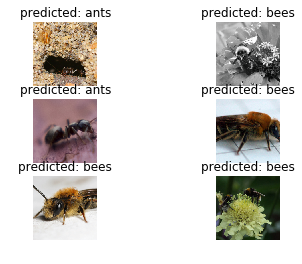

In [159]:
visualize_model(model_conv)

In [114]:
from PIL import Image

loader = transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

In [115]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image)
    image.unsqueeze_(0)
    image = Variable(image, requires_grad=True)
    return image

In [135]:
input_image = 'Test/ant.jpeg'
#print(input_image.size())

AttributeError: numpy

In [120]:
print(image.size())

torch.Size([1, 3, 224, 224])


In [127]:
model_conv.eval()

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [128]:
prediction = model_conv(image)

In [129]:
softmax = nn.Softmax()

In [130]:
softmax_out = softmax(prediction)[0]

In [131]:
ant_prob = softmax_out.data[0]
bees_prob = softmax_out.data[1]

In [132]:
print(ant_prob)

0.9998766779899597


In [133]:
print(bees_prob)

0.00012332752521615475


In [160]:
def test_model(model, num_images=2):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dset_loaders['test']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[labels.data[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

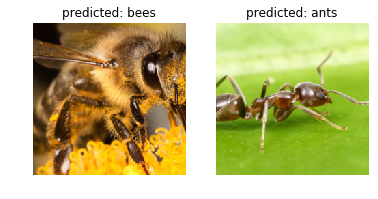

In [162]:
test_model(model_conv)